In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [9]:
df = pd.read_csv('Amreli NRM data for model building2.csv')
# campaign = np.unique(df['campaign'])

# for c in campaign:
#     dfc = df[df['campaign']==c]
#     i = dfc.index[0]
#     df = df.drop(i)
df = df[df['Heat number (life number)']>1]    
df = df.reset_index(drop=True)
df['Number of capacitors removed'].fillna(0, inplace=True)
threshold = 150

for i in range(df.shape[0]):
    if(df.loc[i,'Total Heat Time previous (minutes)']>threshold):
        df.loc[i,'Total Heat Time previous (minutes)']= threshold
    if(df.loc[i,'Total Heat Time (minutes)']>threshold):
        df.loc[i,'Total Heat Time (minutes)']= threshold
        
df['Input energy previous (KWH)'] = df['Power previous']*df['Total Heat Time previous (minutes)']/60
df['Input energy (KWH)'] = df['Power']*df['Total Heat Time (minutes)']/60

# Model 5: All inputs and All outputs 

In [10]:
df.columns

Index(['campaign', 'Heat number (life number)',
       'Total Heat Time previous (minutes)', 'Total Heat Time (minutes)',
       'Scrap (MT)', 'Sponge (MT)', 'Hot Heel (MT)', 'Alloys (MT)',
       'Input (MT)', 'Final C%', 'Tapping Temperature (C)', 'Output (MT)',
       'Input energy previous (KWH)', 'Input energy (KWH)', 'Previous Voltage',
       'Previous Frequency', 'Previous Rating of the Furnace', 'Voltage',
       'Frequency', 'Rating of the furnace (KW)', 'Melt rate (MT/Hr)',
       'Efficiency (MT/KWH)', 'Number of capacitors removed',
       'Refractory lining before heating', 'Refractory lining after heating',
       'Previous Input', 'Previous Output', 'Power', 'Power previous'],
      dtype='object')

In [14]:
input_columns = ['Scrap (MT)', 'Sponge (MT)', 'Hot Heel (MT)', 'Alloys (MT)','Previous Input','Previous Voltage', 'Total Heat Time previous (minutes)',
                 'Previous Frequency','Previous Rating of the Furnace','Previous Output', 'Refractory lining before heating','Number of capacitors removed','Tapping Temperature (C)','Input energy previous (KWH)']
output_columns = ['Total Heat Time (minutes)']
# input_columns = ['Input (MT)','Previous Voltage', 
#                  'Previous Frequency','Previous Rating of the Furnace', 'Refractory lining before heating','Tapping Temperature (C)']
# output_columns = ['Efficiency (MT/KWH)','Total Heat Time (minutes)','Voltage','Frequency','Refractory lining after heating']

In [15]:
X = df[input_columns]
y = df[output_columns]
X_s = df[input_columns]
# from sklearn.preprocessing import MinMaxScaler
# scaler1 = MinMaxScaler()
# scaler2 = MinMaxScaler()
# X = scaler1.fit_transform(X_s)
X = X_s.values
X_train = X[:318,:]
X_test = X[318:,:]
y_s = df[output_columns]
y_s1 = y_s.iloc[:318,:].values
y_s2 = y_s.iloc[318:,:].values
y = y_s.values
# y = scaler2.fit_transform(y_s)
y_train = y[:318,:]
y_test = y[318:,:]

In [17]:

import xgboost as xgb
# xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
#                  max_depth = 10, alpha = 10, n_estimators = 50000)
# xg_reg.fit(X_train,y_train)
# pred_train = xg_reg.predict(X_train)
# pred_test = xg_reg.predict(X_test)
data_dmatrix_train = xgb.DMatrix(data=X_train,label=y_train)
data_dmatrix_test = xgb.DMatrix(data=X_test,label=y_test)

params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 10, 'alpha': 10}

# cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
#                     num_boost_round=500,early_stopping_rounds=100,metrics="rmse", as_pandas=True, seed=123)
# print(cv_results)



ModuleNotFoundError: No module named 'xgboost'

In [ ]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix_train, num_boost_round=50)
# boost 60, for no scaling 
pred_train = xg_reg.predict(data_dmatrix_train)
pred_test = xg_reg.predict(data_dmatrix_test)

In [ ]:
# base = 5
# y_pred_fintrain = base*np.round(scaler2.inverse_transform(pred_train.reshape(-1,1))/base)
# y_pred_fintest =  base*np.round(scaler2.inverse_transform(pred_test.reshape(-1,1))/base)
base = 5

y_pred_fintrain =  base * np.round(pred_train.reshape(-1,1)/base)
y_pred_fintest =   base * np.round(pred_test.reshape(-1,1)/base)


In [ ]:
for i in range(1):
    print(output_columns[i])
    print("Train score is {}".format(mean_squared_error(y_s1, y_pred_fintrain)))
    print("Test score is {}".format(mean_squared_error(y_s2, y_pred_fintest)))
    print("R2 score is {}".format(r2_score(y_s2, y_pred_fintest)))
    print("Train NMSE score is {}".format(np.sum(np.square(y_pred_fintrain-y_s1))/np.sum(np.square(y_s1[:,i]-np.mean(y_s1[:,i])))*100))
    print("Test NMSE score is {}".format(np.sum(np.square(y_pred_fintest-y_s2))/np.sum(np.square(y_s2[:,i]-np.mean(y_s2[:,i])))*100))



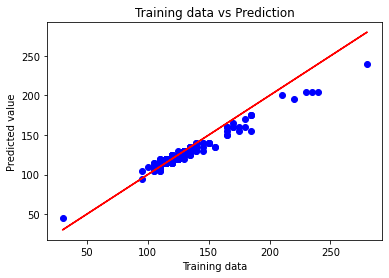

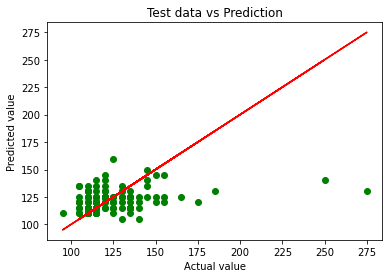

In [12]:
for i in range(1):
    plt.scatter(y_s1, y_pred_fintrain, c='b');
    plt.plot(y_s1,y_s1, c='r');
    plt.xlabel('Training data')
    plt.ylabel('Predicted value')
    plt.title('Training data vs Prediction')
    plt.show()
    plt.scatter(y_s2, y_pred_fintest, c='g');
    plt.plot(y_s2,y_s2,c='r')
    plt.xlabel('Actual value')
    plt.ylabel('Predicted value')
    plt.title('Test data vs Prediction')
    plt.show()


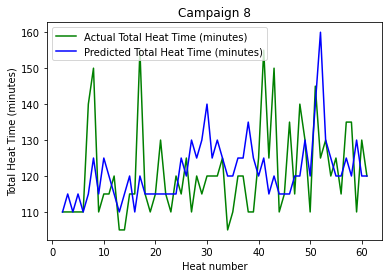

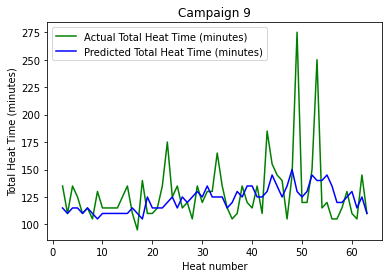

In [11]:
plt.plot(range(2,62),y_s2[:60],c='g');
plt.plot(range(2,62),y_pred_fintest[:60],c='b');
plt.xlabel('Heat number')
plt.ylabel('Total Heat Time (minutes)')
plt.title('Campaign 8')
plt.legend(['Actual Total Heat Time (minutes)','Predicted Total Heat Time (minutes)'])
plt.show()
plt.plot(range(2,64),y_s2[60:],c='g');
plt.plot(range(2,64),y_pred_fintest[60:],c='b');
plt.xlabel('Heat number')
plt.ylabel('Total Heat Time (minutes)')
plt.legend(['Actual Total Heat Time (minutes)','Predicted Total Heat Time (minutes)'])
plt.title('Campaign 9')
plt.show()

# import pickle
# pickle.dump(xg_reg, open('D:\customerdatacompilation\Models\Efficiency_nonlin_model.pkl', 'wb')) 